In [1]:
### To do
# Join the pipeline with Bboxes from Yolo properly (done)
# Ensure name and classes are transferred too (done)
# Resizing of the segmented masks will have to be done (done)
# Why are some masks getting truncated when being saved to json format (done)
 ### ^^^ (Most probably the max area a detection can take becomes a problem when you are creating a detectionDataset with small image and big detections)
# What happens if the input is images of different dimensions?
# color correction and preprocessing?

# Depending on the number of annotation points, some "might" have to be discarded to ensure ease of reannotation
# Color correction of image when being processed at different steps and being saved

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

import sys
from IPython import display
display.clear_output()

# sam
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# ultralytics
!pip install ultralytics==8.0.20

# other installations
!pip install -q roboflow dataclasses-json supervision

In [4]:
import ultralytics
from ultralytics import YOLO
from IPython.display import display, Image
import torch

import cv2
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np

ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/78.2 GB disk)


In [5]:
## create space for yolo model

%cd {HOME}
!mkdir {HOME}/yolo_model
%cd {HOME}/yolo_model

/content
/content/yolo_model


In [ ]:
# ## load yolo model dataset
# %cd {HOME}

# from roboflow import Roboflow
# rf = Roboflow(api_key="ask-ishan")
# project = rf.workspace("ishan-nangia-v1cd3").project("coral-detection-ci")
# dataset = project.version(2).download("yolov8")

### Loading Models

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
model = YOLO(f'/content/drive/MyDrive/Coastal Impact/yolo_model.pt')

In [ ]:
### use this if you have locally placed your model
# model = YOLO(f'{HOME}/yolo_model/yolo_model.pt')

In [8]:
# loading sam and its weights
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

/content
/content/weights
/content/weights/sam_vit_h_4b8939.pth ; exist: True


### Image for Inference

In [46]:
def load_image(img_name, img_address, resized_image_size):
  # load single image
  image_bgr = cv2.imread(img_address)
  original_image_size = image_bgr.shape[1], image_bgr.shape[0]

  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  resized_image = cv2.resize(image_rgb, resized_image_size) # for inference in YOLO

  print("Original Image Size:", original_image_size)
  return image_bgr, image_rgb, resized_image, original_image_size


def draw_bboxes_xyxyn(bboxes, img):
  colors = [(150, 150, 150)]
  drawn_img = img.copy()
  for i, box in enumerate(bboxes):
    x, y, x1, y1 = box
    x, x1 = x*img.shape[1], x1*img.shape[1]
    y, y1 = y*img.shape[0], y1*img.shape[0]
    cv2.rectangle(drawn_img, (int(x), int(y)), (int(x1), int(y1)), colors[0], 10)
  return drawn_img


def get_sam_masks(yolo_result, sam, resized_image):
  # multiple bounding boxes as input for a single image
  input_boxes = yolo_result.boxes.xyxy
  class_ids = yolo_result.boxes.cls.cpu().numpy()

  mask_predictor = SamPredictor(sam)
  transformed_boxes = mask_predictor.transform.apply_boxes_torch(input_boxes, resized_image.shape[:2])
  mask_predictor.set_image(resized_image)
  masks, iou_predictions, low_res_masks = mask_predictor.predict_torch(
      point_coords=None,
      point_labels=None,
      boxes=transformed_boxes,
      multimask_output=False
  )
  return masks, class_ids

def create_detections(masks, class_ids):
  # creating Detections object for all the masks
  xyxys = np.array([sv.mask_to_xyxy(masks=i.cpu()) for i in masks])
  xyxys = xyxys.squeeze(1)
  numpy_masks = masks.cpu().numpy().squeeze(1)
  detections = sv.Detections(
        class_id = class_ids,
        xyxy=xyxys,
        mask=numpy_masks
  )
  return detections

def draw_masks_image(image_bgr, detections):
  # bounding boxes and segmented areas
  box_annotator = sv.BoxAnnotator(color=sv.Color.red(), thickness=10)
  mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
  source_image = image_bgr.copy()
  segmented_image = image_bgr.copy()

  source_image = box_annotator.annotate(scene=source_image,
                                        detections=detections,
                                        skip_label=False)
  segmented_image = mask_annotator.annotate(scene=segmented_image,
                                            detections=detections)

  # plot_grid = sv.plot_images_grid(
  #       images=[source_image, segmented_image],
  #       grid_size=(1, 2),
  #       titles=['image with SAM BB', 'segmented image'],
  #       size=(20, 20)
  #   )
  return segmented_image

In [122]:
# Enter inference image details

img_name = "ci_9.jpg"
img_address = f"/content/{img_name}"

resized_image_size = (640, 490) # part of preprocessing of images for yolo v8

image_bgr, image_rgb, resized_image, original_image_size = load_image(img_name, img_address, resized_image_size)

Original Image Size: (8000, 6016)


### YOLO

In [123]:
# Get inference

results = model.predict(resized_image)
image_with_bbox = draw_bboxes_xyxyn(results[0].boxes.xyxyn, image_rgb)

# # class: 1 = ref, 0 = coral
# print(results[0].boxes.cls)
# print(results[0].boxes.xyxyn)

### SAM

In [124]:
masks, class_ids = get_sam_masks(results[0], sam, resized_image)

In [125]:
# resizing segmentation map
big_masks = [torch.nn.functional.interpolate(i.to(torch.float32).unsqueeze(0),
                                             size=(original_image_size[1], original_image_size[0])).to(bool)
                                             for i in masks]
big_masks = torch.stack(big_masks).squeeze(1)

### Results visualisation with Supervision

In [126]:
detections = create_detections(big_masks, class_ids)

In [127]:
segmented_image = draw_masks_image(image_bgr, detections)

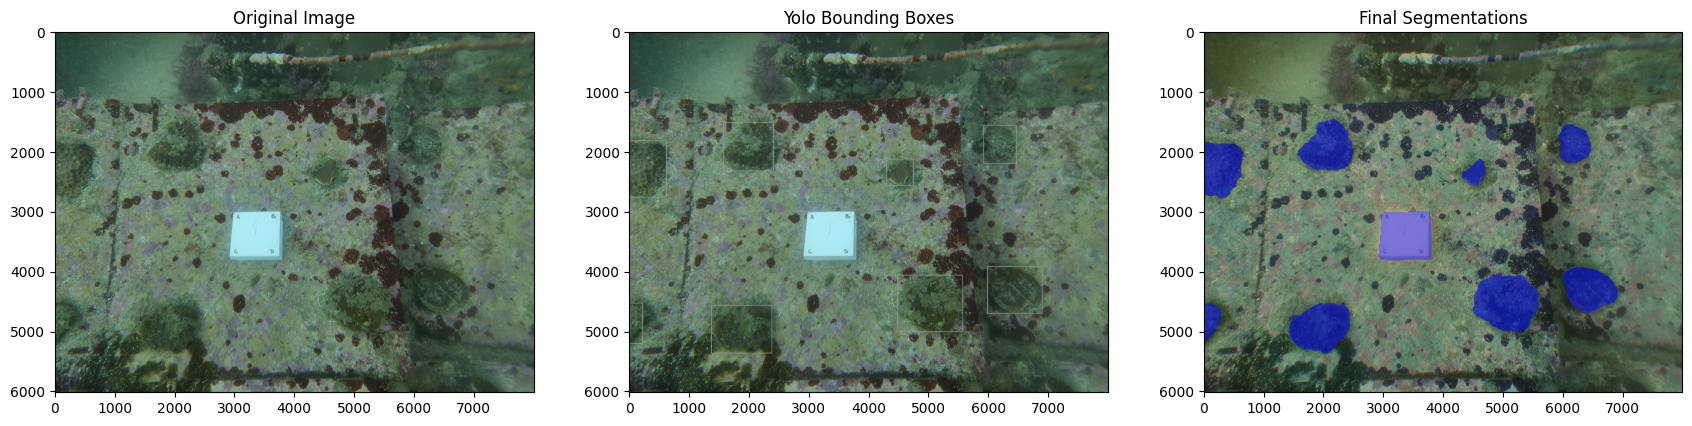

In [128]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
ax[0].imshow(image_rgb)
ax[1].imshow(image_with_bbox)
ax[2].imshow(segmented_image)

ax[0].set_title('Original Image')
ax[1].set_title('Yolo Bounding Boxes')
ax[2].set_title('Final Segmentations')
fig.savefig(f"/content/grid_{img_name}")

In [ ]:
inference_dataset = sv.DetectionDataset(["coral", 'ref'],
                                        {f"{img_name}": image_rgb},
                                        {f"{img_name}": detections})

In [ ]:
%cd {HOME}

inference_dataset.as_coco(annotations_path="./coco_inference.json",
                          approximation_percentage=0)

/content
